In [1]:
import torch
import os
import json
import pickle
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys

sys.path.insert(0, '..')
import utils

In [2]:
tmp = utils.MNIST_Network()

# Visualize Trojan triggers

Here, we visualize the triggers in the provided attack specifications.

In [11]:
_, test_data, _ = utils.load_data('MNIST')

dataset_path = '../../tdc_datasets'
task = 'evasive_trojans'

with open(os.path.join(dataset_path, task, 'val', 'attack_specifications.pkl'), 'rb') as f:
    attack_specifications = pickle.load(f)

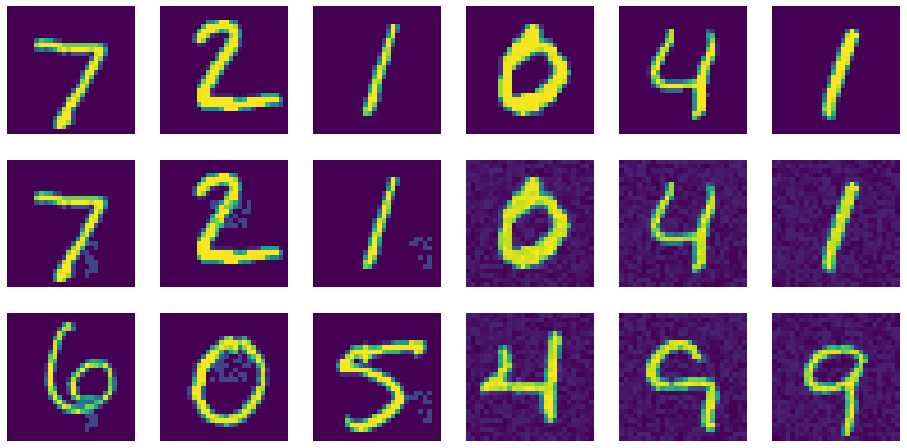

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = test_data[i][0].unsqueeze(0)
    attack_specification = attack_specifications[i*35]
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = test_data[100+i][0].unsqueeze(0)
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

Your job is to create hard-to-detect Trojans according to these attack specifications.

# Check whether specifications are met

We assume you have trained a dataset of Trojaned neural networks, one for each provided attack specification. This code checks whether the attack specifications are satisfied. Namely, it tests whether the average attack success rate (ASR) of the submitted Trojaned neural networks is at least 97%. If the average ASR is below 97%, then your submission will be rejected by the evaluation server.

In [13]:
trojan_model_dir = './models/trojan_evasion'

In [14]:
def check_specifications(model_dir, attack_specifications):
    """
    Checks whether the dataset of networks in model_dir satisfy the provided attack specifications
    
    :param model_dir: a directory with subdirectories 'id-0000', 'id-0001', etc. Each subdirectory
                     contains a model.pt file which can be loaded directly with torch.load, to give
                     a trojaned neural network
    :param attack_specifications: a list of attack specificaitons, which the provided Trojaned networks
                                  must satisfy (i.e., achieve an average attack success rate >= 97%)
    :returns: whether the test passes, and the list of attack success rates
    """
    _, test_data, _ = utils.load_data('MNIST')
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False, pin_memory=True,
                                              num_workers=4)
    
    attack_success_rates = []

    for model_idx in tqdm(range(200)):
        model = torch.load(os.path.join(model_dir, 'id-{:04d}'.format(int(model_idx)), 'model.pt'))
        model.cuda().eval()
        _, asr = utils.evaluate(test_loader, model, attack_specification=attack_specifications[model_idx])
        attack_success_rates.append(asr)
    
    if np.mean(attack_success_rates) >= 0.97:
        result = True
    else:
        result = False
    
    return result, attack_success_rates

In [15]:
result, attack_success_rates = check_specifications(trojan_model_dir, attack_specifications)

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
print('Passes test (mean ASR >= 97%):', result)
print('Mean ASR: {:.1f}%'.format(100*np.mean(attack_success_rates)))
print('Std ASR: {:.1f}%'.format(100*np.std(attack_success_rates)))

Passes test (mean ASR >= 97%): True
Mean ASR: 98.3%
Std ASR: 0.9%


# Evaluate Trojan detectors on submission

In [22]:
trojan_model_dir = './models/trojan_evasion'

dataset_path = '../../tdc_datasets'
task = 'evasive_trojans'
clean_model_dir = os.path.join(dataset_path, task, 'reference_models')

The following code runs three Trojan detectors on the networks in `trojan_model_dir` and `clean_model_dir`, which contain the trained dataset of Trojaned networks and a reference dataset of clean networks respectively. This enables testing the performance of your networks before submitting to the evaluation server.

## Accuracy-based detector

This detector compares the test accuracies of the clean and Trojaned models.

In [23]:
def compute_accuracies(model_dir):
    """
    Computes the test accuracy of each MNIST network in model_dir
    
    :param model_dir: a directory with subdirectories 'id-0000', 'id-0001', etc. Each subdirectory
                      contains a model.pt file which can be loaded directly with torch.load
    :returns: the list of test accuracies
    """
    _, test_data, _ = utils.load_data('MNIST')
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False, pin_memory=True,
                                              num_workers=4)
    
    accuracies = []

    for model_idx in tqdm(range(200)):
        model = torch.load(os.path.join(model_dir, 'id-{:04d}'.format(int(model_idx)), 'model.pt'))
        model.cuda().eval()
        _, acc = utils.evaluate(test_loader, model)
        accuracies.append(acc)
    
    return accuracies

In [24]:
scores_trojan = compute_accuracies(trojan_model_dir)
scores_clean = compute_accuracies(clean_model_dir)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
scores = -1 * np.concatenate([scores_trojan, scores_clean])
labels = np.concatenate([np.ones(len(scores_trojan)), np.zeros(len(scores_clean))])

print('Accuracy-based detector AUROC: {:.1f}%'.format(100 * roc_auc_score(labels, scores)))

Accuracy-based detector AUROC: 69.7%


## Specificity-based detector

In [39]:
trojan_model_dir = './models/trojan_evasion'

dataset_path = '../../tdc_datasets'
task = 'evasive_trojans'
clean_model_dir = os.path.join(dataset_path, task, 'reference_models')

This detector examines the posterior entropy of clean and Trojaned networks when given triggers from the same distribution as the provided attack specifications (we assume the defender knows the trigger distribution, but not the specific triggers in the provided attack specifications).

If the Trojaned networks in `trojan_model_dir` have low specificity (i.e., they activate not only for the intended triggers but also for arbitrary triggers), then it may be easy to notice that something is amiss, motivating this detector.

In [27]:
def compute_avg_posterior(loader, model, attack_specification=None):
    """
    :param loader: data loader
    :param model: model to compute average posterior for
    :param attack_specification: specifies the Trojan trigger to insert (uses clean images if None)
    :returns: the average posterior across the images in loader
    """
    with torch.no_grad():
        avg_posterior = torch.zeros(10)
        
        for i, batch in enumerate(loader):
            bx = batch[0].cuda()
            by = batch[1].cuda()
            
            if attack_specification is not None:
                bx, by = utils.insert_trigger(bx, attack_specification)
            
            logits = model(bx)
            avg_posterior += torch.softmax(logits, dim=1).mean(0).cpu()
        avg_posterior /= len(loader)
    
    return avg_posterior.numpy()

In [36]:
def compute_specificity_scores(model_dir):
    print(model_dir)
    scores = []

    for model_idx in tqdm(range(200)):
        model = torch.load(os.path.join(model_dir, 'id-{:04d}'.format(int(model_idx)), 'model.pt'))
        model.cuda().eval()
        entropy_list = []
        
        # randomly generate 5 patch triggers and 5 blended triggers
        negative_specs = utils.generate_attack_specifications(np.random.randint(1e5), 5, 'patch')
        negative_specs += utils.generate_attack_specifications(np.random.randint(1e5), 5, 'blended')
        for i in range(10):  # try out 10 random triggers per network
            attack_specification = negative_specs[i]
            avg_posterior = compute_avg_posterior(test_loader, model, attack_specification)
            # compute entropy
            entropy = -1 * (np.log(avg_posterior) * avg_posterior).sum()
            entropy_list.append(entropy)
        
        scores.append(np.mean(entropy_list) * -1)  # non-specific Trojaned models should have lower entropy
    
    return scores

In [40]:
_, test_data, _ = utils.load_data('MNIST')
subset_indices = np.arange(len(test_data))
np.random.shuffle(subset_indices)
test_data = torch.utils.data.Subset(test_data, subset_indices[:1000])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False, pin_memory=True,
                                          num_workers=4)

scores_trojan = compute_specificity_scores(trojan_model_dir)
scores_clean = compute_specificity_scores(clean_model_dir)

./models/trojan_evasion


  0%|          | 0/200 [00:00<?, ?it/s]

../../tdc_datasets/evasive_trojans/reference_models


  0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
scores = np.concatenate([scores_trojan, scores_clean])
labels = np.concatenate([np.ones(len(scores_trojan)), np.zeros(len(scores_clean))])

print('Specificity-based detector AUROC: {:.1f}%'.format(100 * roc_auc_score(labels, scores)))

Specificity-based detector AUROC: 72.0%


## MNTD detector

In [42]:
class NetworkDatasetDetection(torch.utils.data.Dataset):
    def __init__(self, trojan_model_dir, clean_model_dir):
        super().__init__()
        model_paths = []
        labels = []
        model_paths.extend([os.path.join(trojan_model_dir, x) for x in os.listdir(trojan_model_dir)])
        labels.extend([1 for i in range(len(os.listdir(clean_model_dir)))])
        model_paths.extend([os.path.join(clean_model_dir, x) for x in os.listdir(clean_model_dir)])
        labels.extend([0 for i in range(len(os.listdir(clean_model_dir)))])
        
        self.model_paths = model_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.model_paths)
    
    def __getitem__(self, index):
        return torch.load(os.path.join(self.model_paths[index], 'model.pt')), self.labels[index]

In [43]:
def custom_collate(batch):
    return [x[0] for x in batch], [x[1] for x in batch]

In [44]:
class MetaNetworkMNIST(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        self.queries = nn.Parameter(torch.rand(num_queries, 1, 28, 28))
        self.output = nn.Linear(10*num_queries, num_classes)
    
    def forward(self, net):
        """
        :param net: an input network of one of the model_types specified at init
        :returns: a score for whether the network is a Trojan or not
        """
        tmp = self.queries
        x = net(tmp)
        return self.output(x.view(1, -1))

In [45]:
def train_meta_network(meta_network, train_loader):
    num_epochs = 10
    lr = 0.01
    weight_decay = 0.
    optimizer = torch.optim.Adam(meta_network.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * len(train_loader.dataset))

    loss_ema = np.inf
    for epoch in range(num_epochs):

        pbar = tqdm(train_loader)
        pbar.set_description(f"Epoch {epoch + 1}")
        for i, (net, label) in enumerate(pbar):
            net = net[0]
            label = label[0]
            net.cuda().eval()

            out = meta_network(net)

            loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0).cuda())

            optimizer.zero_grad()
            loss.backward(inputs=list(meta_network.parameters()))
            optimizer.step()
            scheduler.step()
            meta_network.queries.data = meta_network.queries.data.clamp(0, 1)
            loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()

            pbar.set_postfix(loss=loss_ema)

In [46]:
def evaluate_meta_network(meta_network, loader):
    loss_list = []
    correct_list = []
    confusion_matrix = torch.zeros(2,2)
    all_scores = []
    all_labels = []
    
    for i, (net, label) in enumerate(tqdm(loader)):
        net[0].cuda().eval()
        with torch.no_grad():
            out = meta_network(net[0])
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label[0]]).unsqueeze(0).cuda())
        correct = int((out.squeeze() > 0).int().item() == label[0])
        loss_list.append(loss.item())
        correct_list.append(correct)
        confusion_matrix[(out.squeeze() > 0).int().item(), label[0]] += 1
        all_scores.append(out.squeeze().item())
        all_labels.append(label[0])
    
    return np.mean(loss_list), np.mean(correct_list), confusion_matrix, all_labels, all_scores

In [47]:
def run_mntd_crossval(trojan_model_dir, clean_model_dir, num_folds=5):
    dataset = NetworkDatasetDetection(trojan_model_dir, clean_model_dir)
    rnd_idx = np.random.permutation(len(dataset))
    
    fold_size = len(dataset) // num_folds
    
    all_scores = []
    all_labels = []
    
    for i in range(num_folds):
        # create split
        train_indices = []
        val_indices = []
        fold_indices = np.arange(fold_size*i, fold_size*(i+1))
        for j in range(len(dataset)):
            if j in fold_indices:
                val_indices.append(rnd_idx[j])
            else:
                train_indices.append(rnd_idx[j])
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,
                                                   num_workers=4, pin_memory=False, collate_fn=custom_collate)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                                 num_workers=4, pin_memory=False, collate_fn=custom_collate)
        
        # initialize MNTD for MNIST
        meta_network = MetaNetworkMNIST(10, num_classes=1).cuda().train()
        
        # train MNTD
        train_meta_network(meta_network, train_loader)
        meta_network.eval()
        
        # evaluate MNTD
        loss, acc, _, labels, scores = evaluate_meta_network(meta_network, val_loader)
        all_labels.extend(labels)
        all_scores.extend(scores)
        print('Fold {}, Test Acc: {:.3f}, AUROC (subset): {:.3f}'.format(i, acc, roc_auc_score(labels, scores)))
    
    final_auroc = roc_auc_score(all_labels, all_scores)
    print('Final AUROC: {:.3f}'.format(final_auroc))
    return final_auroc

In [48]:
trojan_model_dir = './models/trojan_evasion'

dataset_path = '../../tdc_datasets'
task = 'evasive_trojans'
clean_model_dir = os.path.join(dataset_path, task, 'reference_models')

auroc = run_mntd_crossval(trojan_model_dir, clean_model_dir, num_folds=5)

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Fold 0, Test Acc: 0.675, AUROC (subset): 0.719


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Fold 1, Test Acc: 0.625, AUROC (subset): 0.669


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Fold 2, Test Acc: 0.700, AUROC (subset): 0.801


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Fold 3, Test Acc: 0.725, AUROC (subset): 0.780


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Fold 4, Test Acc: 0.675, AUROC (subset): 0.750
Final AUROC: 0.744


In the evaluation server, MNTD cross-validation is run three times, and the AUROC values are averaged. A single run gives a good estimate, though.

# Make submission

Makes a submission using the models in the ./models/trojan_evasion folder.

In [50]:
!cd models/trojan_evasion && zip -r ../../submission.zip ./* && cd ../..

  adding: id-0000/ (stored 0%)
  adding: id-0000/model.pt (deflated 8%)
  adding: id-0000/info.json (deflated 31%)
  adding: id-0001/ (stored 0%)
  adding: id-0001/model.pt (deflated 8%)
  adding: id-0001/info.json (deflated 31%)
  adding: id-0002/ (stored 0%)
  adding: id-0002/model.pt (deflated 8%)
  adding: id-0002/info.json (deflated 31%)
  adding: id-0003/ (stored 0%)
  adding: id-0003/model.pt (deflated 8%)
  adding: id-0003/info.json (deflated 30%)
  adding: id-0004/ (stored 0%)
  adding: id-0004/model.pt (deflated 8%)
  adding: id-0004/info.json (deflated 31%)
  adding: id-0005/ (stored 0%)
  adding: id-0005/model.pt (deflated 8%)
  adding: id-0005/info.json (deflated 31%)
  adding: id-0006/ (stored 0%)
  adding: id-0006/model.pt (deflated 8%)
  adding: id-0006/info.json (deflated 32%)
  adding: id-0007/ (stored 0%)
  adding: id-0007/model.pt (deflated 8%)
  adding: id-0007/info.json (deflated 31%)
  adding: id-0008/ (stored 0%)
  adding: id-0008/model.pt (deflated 8%)
  adding

  adding: id-0071/model.pt (deflated 8%)
  adding: id-0071/info.json (deflated 31%)
  adding: id-0072/ (stored 0%)
  adding: id-0072/model.pt (deflated 8%)
  adding: id-0072/info.json (deflated 32%)
  adding: id-0073/ (stored 0%)
  adding: id-0073/model.pt (deflated 8%)
  adding: id-0073/info.json (deflated 32%)
  adding: id-0074/ (stored 0%)
  adding: id-0074/model.pt (deflated 8%)
  adding: id-0074/info.json (deflated 31%)
  adding: id-0075/ (stored 0%)
  adding: id-0075/model.pt (deflated 8%)
  adding: id-0075/info.json (deflated 31%)
  adding: id-0076/ (stored 0%)
  adding: id-0076/model.pt (deflated 8%)
  adding: id-0076/info.json (deflated 30%)
  adding: id-0077/ (stored 0%)
  adding: id-0077/model.pt (deflated 8%)
  adding: id-0077/info.json (deflated 31%)
  adding: id-0078/ (stored 0%)
  adding: id-0078/model.pt (deflated 8%)
  adding: id-0078/info.json (deflated 32%)
  adding: id-0079/ (stored 0%)
  adding: id-0079/model.pt (deflated 8%)
  adding: id-0079/info.json (deflated 3

  adding: id-0143/model.pt (deflated 8%)
  adding: id-0143/info.json (deflated 31%)
  adding: id-0144/ (stored 0%)
  adding: id-0144/model.pt (deflated 8%)
  adding: id-0144/info.json (deflated 32%)
  adding: id-0145/ (stored 0%)
  adding: id-0145/model.pt (deflated 8%)
  adding: id-0145/info.json (deflated 32%)
  adding: id-0146/ (stored 0%)
  adding: id-0146/model.pt (deflated 8%)
  adding: id-0146/info.json (deflated 32%)
  adding: id-0147/ (stored 0%)
  adding: id-0147/model.pt (deflated 8%)
  adding: id-0147/info.json (deflated 31%)
  adding: id-0148/ (stored 0%)
  adding: id-0148/model.pt (deflated 8%)
  adding: id-0148/info.json (deflated 32%)
  adding: id-0149/ (stored 0%)
  adding: id-0149/model.pt (deflated 8%)
  adding: id-0149/info.json (deflated 31%)
  adding: id-0150/ (stored 0%)
  adding: id-0150/model.pt (deflated 8%)
  adding: id-0150/info.json (deflated 32%)
  adding: id-0151/ (stored 0%)
  adding: id-0151/model.pt (deflated 8%)
  adding: id-0151/info.json (deflated 3